In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import sys
import matplotlib.pyplot as plt
from pandas_ml_quant import pd, np

automatically imported pandas_ml_quant 0.1.4
automatically imported pandas_ml_utils 0.1.4


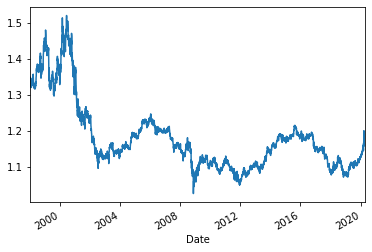

In [2]:
pairs = ("SPY", "DIA")
df = pd.fetch_yahoo(*pairs, multi_index=True)
df = df[pairs[0]] / df[pairs[1]]
df["Close"].plot()

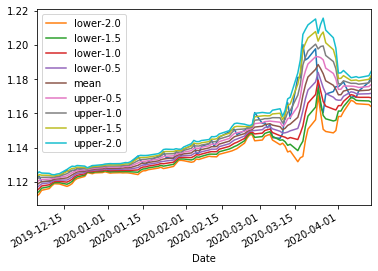

In [3]:
ax = df["Close"][-90:].plot()
df["Close"].ta.multi_bbands(period=7)[-90:].plot(ax=ax)

In [4]:
from pandas_ml_utils import FeaturesAndLabels, Model, KerasModel
from pandas_ml_utils.ml.data.splitting.sampeling import KEquallyWeightEvents
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_quant import PostProcessedFeaturesAndLabels
from pandas_ml_quant.keras.loss import tailed_categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, ActivityRegularization
from keras.callbacks import EarlyStopping
from keras import backend as K 

# firs clear tensorflow session
K.clear_session()


# define the model provider
def baseline_model():    
    # create model
    model = Sequential()
    model.add(Reshape((280 * 11, ), input_shape=(280, 11)))
    model.add(ActivityRegularization(l1=0.002))
    model.add(Dense(60, activation='tanh'))
    model.add(Dense(50, activation='tanh'))
    model.add(Dense(9, activation='softmax'))
    
    loss = tailed_categorical_crossentropy(9, alpha=1)
    model.compile(loss=loss,
                  optimizer=Adam(lr=0.001), 
                  metrics=['accuracy'],
                 )
    
    return model, loss


baseline_model()


fit = df.model.fit(
    KerasModel(
        baseline_model,
        PostProcessedFeaturesAndLabels(
            features=[
                lambda df: df["Close"].ta.apo(),
                lambda df: df["Close"].ta.mom(),
                lambda df: df["Close"].ta.trix(),
                lambda df: df["Close"].ta.macd(),
                lambda df: df.ta.atr(),
                lambda df: df.ta.adx()[['-DI', '+DI', '-DM', '+DM']]
            ],
            feature_post_processor=[
                lambda df: df.ta.rnn(range(280))
            ],
            labels=[
                # multi bollinger bands one hot .... 
                lambda df: df["Close"].ta.future_multi_bband_quantile(period=7, forecast_period=7, stddevs=np.arange(0.5, 4.8, 1.1), include_mean=False).ta.one_hot_encode_discrete()
            ],
            targets=[
                # multi bollinger bands
                lambda df: df["Close"].ta.multi_bbands(period=7, stddevs=np.arange(0.5, 4.8, 1.1), include_mean=False)
            ],
            gross_loss=None,
            sample_weights=None
        ),
        summary_provider=ClassificationSummary,
        forecasting_time_steps=7,
    ),
    RandomSplits(test_size=0.4,
                 # youngest_size=0.05,
                 test_validate_split_seed=42,
                 cross_validation=(1, KEquallyWeightEvents(n_splits=3).split)),
    # keras fit parameters
    # callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], 
    verbose=0,
)

fit

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


pass args to fit: {'callbacks': [], 'verbose': 0}
pass args to fit: {'callbacks': [], 'verbose': 0}
pass args to fit: {'callbacks': [], 'verbose': 0}


In [5]:
pred = df.model.predict(fit.model, tail=1)
pred.map_prediction_to_target()

prediction
2020-04-14 (-inf, 1.15)    0.086604
           (1.15, 1.16)    0.121638
           (1.16, 1.17)    0.135212
           (1.17, 1.17)    0.106175
           (1.17, 1.18)    0.084379
           (1.18, 1.18)    0.090884
           (1.18, 1.19)    0.099328
           (1.19, 1.19)    0.137272
           (1.19, inf)     0.138509

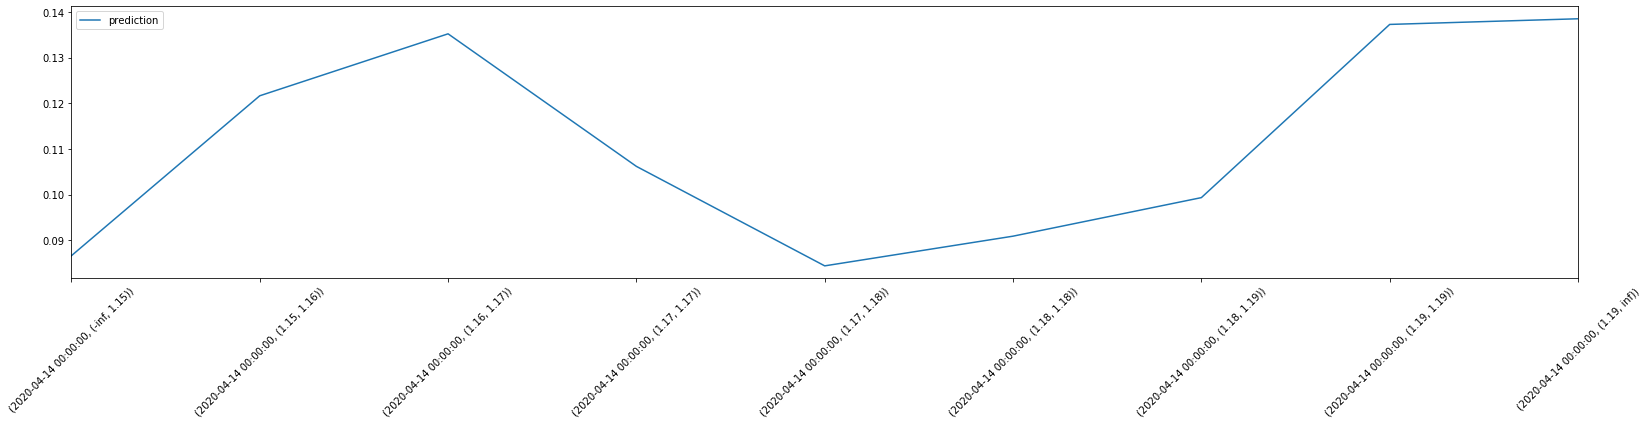

In [6]:
ax = pred.map_prediction_to_target().plot(figsize=(27, 5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)